In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn.functional as F

# torch.autograd.set_detect_anomaly(True)
torch.set_default_dtype(torch.float32)

import mediapy as mpy
from tqdm.auto import tqdm
from IPython.display import clear_output, display

from nca_model import NCAModel
from utils import nca_out_to_vids
from mnist_data import MNISTGenerator
from clf_patterns import RadialCirclesProcessor, generate_start_pattern

In [3]:
device = "cuda"
num_classes = 10
chans = 16
bs = 32
S = 64
lr = 0.001

In [4]:
nca = NCAModel(channel_n=chans, device=device)

In [5]:
inp = torch.rand(5, chans, S, S).to(device)
out = nca(inp, steps=50)
len(out), out[0].shape

(51, torch.Size([5, 16, 64, 64]))

,,,,

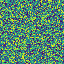
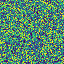
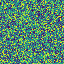
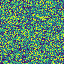
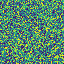

In [6]:
nca_out_to_vids(out)

In [7]:
gen = MNISTGenerator(bs=bs, num_classes=num_classes)

In [8]:
radial_processor = RadialCirclesProcessor(num_classes=num_classes, S=S)
start_pattern = generate_start_pattern(num_classes=num_classes, S=S)

""

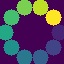

In [9]:
mpy.show_image(radial_processor.screen, cmap="viridis", width=150)

""

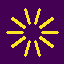

In [10]:
mpy.show_image(start_pattern, cmap="viridis", width=150)

In [11]:
batch = next(gen)
inp, out = radial_processor.map_batch(batch, chans=chans)

,,,,,,,

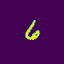
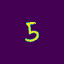
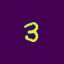
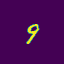
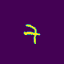
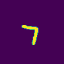
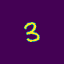
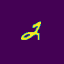

In [12]:
mpy.show_images(inp[:8,0], cmap="viridis", width=100, columns=8)

,,,,,,,

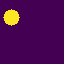
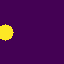
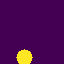
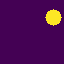
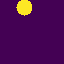
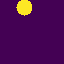
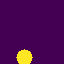
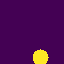

In [13]:
mpy.show_images(out[:8], cmap="viridis", width=100, columns=8)

In [14]:
nca = NCAModel(channel_n=chans, device=device)
train_gen = MNISTGenerator(bs=bs, num_classes=num_classes)

radial_processor = RadialCirclesProcessor(num_classes=num_classes, S=S)
start_pattern = generate_start_pattern(num_classes=num_classes, S=S)
start_pattern = start_pattern.to(inp.dtype).to(device)
start_pattern = start_pattern.unsqueeze(0).repeat(bs, 1, 1)

optim = torch.optim.Adam(nca.parameters(), lr=lr)

In [15]:
inp.sum()

tensor(9821.2109)

Loss: 0.2104602903:   0%|          | 0/50000 [00:00<?, ?it/s]

,,,,,,,,,,,,,,,

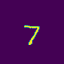
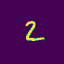
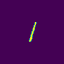
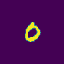
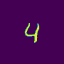
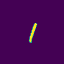
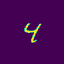
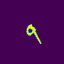
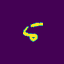
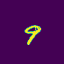
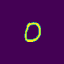
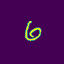
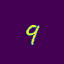
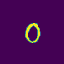
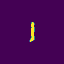
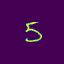

In [ ]:
pbar = tqdm(range(50_000))

for i in pbar:
    batch = next(train_gen)
    inp, out_gt = radial_processor.map_batch(batch, chans=chans)
    out_gt = out_gt.to(device)

    steps = np.random.randint(50, 51)
    out_pred = nca(inp.to(device), steps=steps)

    mid_frame = out_pred[25][:, 0]
    last_frame = out_pred[-1][:, 0]

    loss = 0
    loss += F.mse_loss(out_gt, last_frame)
    loss += F.mse_loss(start_pattern, mid_frame)

    optim.zero_grad()
    loss.backward()
    optim.step()

    pbar.set_description(f"Loss: {loss:.10f}")
    if i % 150 == 0:
        clear_output()
        display(pbar.container)
        
        test_gen = MNISTGenerator(bs=16, num_classes=num_classes, is_train=False)
        batch = next(test_gen)
        inp, out_gt = radial_processor.map_batch(batch, chans=chans)
        out_pred = nca(inp.to(device), steps=50)
        nca_out_to_vids(out_pred)